<font size=6>Ocean Data Analysis - Analyzing Sea Surface Temperature w/ Variational Inference</font>

Interesting Research
https://www.nature.com/articles/s41467-018-08066-0

In [3]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
!pip install netcdf4
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 
import scipy.stats as stats 

import seaborn as sns
sns.set()

In [4]:
# Buoy in Gulf of Maine
ds = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44007/44007.ncml')
ds = ds.sel(time=slice('2021-3-30','2023-5-12'))
print(ds)

# Get buoy data from NOAA
noaa_df = ds.to_dataframe().reset_index()
print(noaa_df)

<xarray.Dataset>
Dimensions:                  (latitude: 1, longitude: 1, time: 109632)
Coordinates:
  * latitude                 (latitude) float32 43.53
  * longitude                (longitude) float32 -70.14
  * time                     (time) datetime64[ns] 2021-03-30 ... 2023-04-30T...
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_tem

In [5]:
# Get sea surface temps
cov = noaa_df[['time','sea_surface_temperature']]
cov = cov.dropna().reset_index().drop(columns=['index'])
cov['sea_surface_temperature'] = cov['sea_surface_temperature'].rolling(24*14).mean()
cov = cov.dropna()
print(cov)

                      time  sea_surface_temperature
335    2021-04-01 10:00:00                 5.362798
336    2021-04-01 10:10:00                 5.364881
337    2021-04-01 10:20:00                 5.366964
338    2021-04-01 10:30:00                 5.369048
339    2021-04-01 10:40:00                 5.371131
...                    ...                      ...
109000 2023-04-30 23:10:00                 7.976786
109001 2023-04-30 23:20:00                 7.973512
109002 2023-04-30 23:30:00                 7.970238
109003 2023-04-30 23:40:00                 7.966964
109004 2023-04-30 23:50:00                 7.963393

[108670 rows x 2 columns]


In [6]:
# Fit mixture model 
num_components = 2
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=1,
    max_iter=100)
p = dpgmm_model.fit_predict(cov['sea_surface_temperature'].to_numpy().reshape(-1,1))

# Count States
state_counts = np.zeros(num_components)
for M in p:
  state_counts[M] += 1 
print(state_counts)

[64291. 44379.]


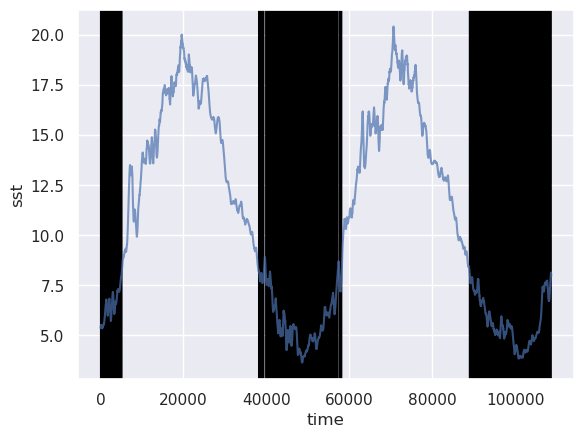

In [7]:
# Plot States
fig2, ax2=plt.subplots()

for M in range(len(p)): 
  if p[M] == p[-1]:
    ax2.axvline(M, color='black', alpha=0.002) 
    
sns.lineplot(data=cov['sea_surface_temperature'].values, ax=ax2, alpha=0.7)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

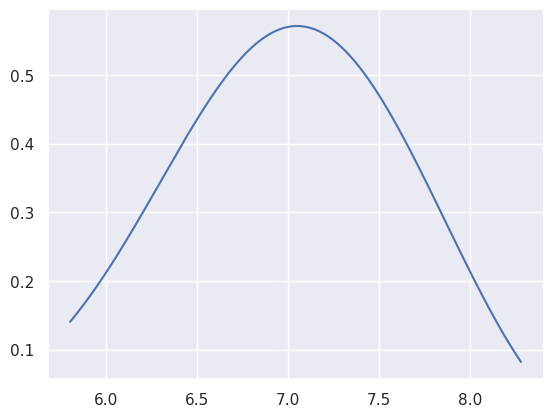

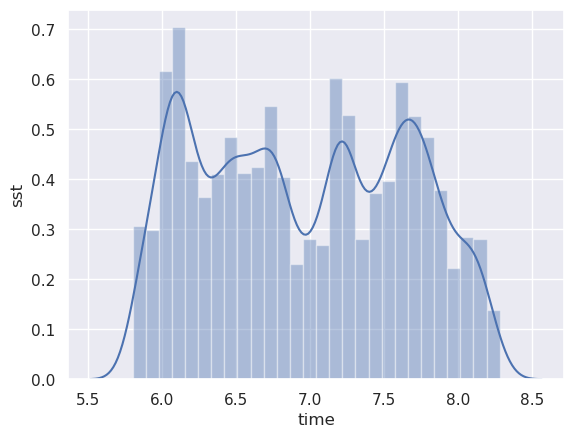

In [18]:
# Plot Generalized Extreme Value Distribution
data=[]
thresh = dpgmm_model.means_[1]
    
for M in range(len(p)): 
  if p[M] == p[-1]:
    yr = str(cov['time'].values[M])[:4]
    mo = str(cov['time'].values[M])[5:7]
    v = cov['sea_surface_temperature'].values[M]
    if v >= thresh:
        data.append(v)

import scipy 
gev_fit = scipy.stats.genextreme.fit(data)

# GEV parameters from fit
c, loc, scale = gev_fit
fit_mean = loc
min_extreme, max_extreme = scipy.stats.genextreme.interval(0.99, c, loc, scale) 

# evenly spread x axis values for pdf plot
x = np.linspace(min(data), max(data),200)

# plot distribution
fig,ax = plt.subplots()
plt.plot(x, scipy.stats.genextreme.pdf(x, *gev_fit))
#plt.hist(data, 10, normed=False, alpha=0.3)
plt.show()

sns.distplot(data)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()